In [ ]:
import numpy as np
from enum import Enum
import random
from typing import Tuple, List, Set, Dict, Optional
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import clear_output
import time
import ipywidgets as widgets

In [ ]:
class grid_cell(Enum):
  block = 0
  open = 1
  fire = 2
  bot = 3
  button = 4

In [23]:
class ship:
  # We are creating constructor method to initialize the ship grid and related parameters.
    def __init__(self, size: int = 40, fire_spread: float = 0.6):
        self.size = size # size of the grid (40x40 by default)
        self.grid = np.zeros((self.size, self.size), dtype=int) # We initialise the grid as a 2d Array of Zeroes
        self.q = fire_spread # This represent probability of fire spreading (0.6 by Default)
        self.bot_pos = None
        self.button_pos = None
        self.start_fire_pos = None
        self.fire_cells = set() # This will store set() of cells which are currently on fire
    #This Method will initialize the grid and set position for bot, button and fire
    def initialize_grid(self):
        self.grid.fill(grid_cell.block.value)
        start_x = random.randint(1, self.size - 2)
        start_y = random.randint(1, self.size - 2)
        self.open_cell(start_x, start_y)

        while True:
            candidates = self.one_neighbour()  #This will get cells with one open neighbour
            if not candidates:
                break
            x, y = random.choice(list(candidates))
            self.open_cell(x, y)

        self.dead_ends() # Handles dead-end cell

        open_cells = []
        for x in range(self.size):
            for y in range(self.size):
                if self.grid[x][y] == grid_cell.open.value:
                    open_cells.append((x, y))

        if len(open_cells) < 3:
            raise ValueError("There are no Open Cells")

        bot_pos, button_pos, start_fire_pos = random.sample(open_cells, 3)
        self.bot_pos = bot_pos  # Assign bot position
        self.button_pos = button_pos # Assign button position
        self.start_fire_pos = start_fire_pos # Assign starting fire position
        self.fire_cells.add(start_fire_pos) # Add fire position to fire set

        self.grid[bot_pos] = grid_cell.bot.value
        self.grid[button_pos] = grid_cell.button.value
        self.grid[start_fire_pos] = grid_cell.fire.value

        self.bot1_strategy()
        self.bot2_strategy()
        self.bot3_strategy()
        self.bot4_strategy()
    # Method to open grid cell by changing its value to open
    def open_cell(self, x, y):
        self.grid[x][y] = grid_cell.open.value
    # Method to get neighbouring cell
    def get_neighbours(self, x: int, y: int) -> List[Tuple[int, int]]:
        neighbours = []
        directions = [(1, 0), (-1, 0), (0, 1), (0, -1)] # all possible directions (up, down, left, right)
        # we check whether the new coo-ordinates are within the grid boundaries
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.size and 0 <= ny < self.size:
              neighbours.append((nx, ny)) # Adding valid neighbour
        return neighbours
    #Method to find block cells with exactly one neighbour
    def one_neighbour(self) -> Set[Tuple[int, int]]:
        candidates = set()
        for x in range(self.size):
            for y in range(self.size):
                if self.grid[x][y] == grid_cell.block.value:
                    open_neighbours_count = 0
                    for nx, ny in self.get_neighbours(x, y):
                        if self.grid[nx][ny] == grid_cell.open.value:
                            open_neighbours_count += 1
                    # if exactly one open neighbour, we will add it to the candidate set.
                    if open_neighbours_count == 1:
                        candidates.add((x, y))
        return candidates
    # Method to handle dead-end cells by opening up adjacent block
    def dead_ends(self):
        dead = []
        for x in range(self.size):
            for y in range(self.size):
                if self.grid[x][y] == grid_cell.open.value:
                    neighbour_count = 0
                    for nx, ny in self.get_neighbours(x, y):
                        if self.grid[nx][ny] == grid_cell.open.value:
                            neighbour_count += 1

                    if neighbour_count == 1:
                        dead.append((x, y))

        half_dead = random.sample(dead, len(dead) // 2)
        for x, y in half_dead:
            blocked_neighbours = []

            for nx, ny in self.get_neighbours(x, y):
                if self.grid[nx][ny] == grid_cell.block.value:
                    blocked_neighbours.append((nx, ny))

            if blocked_neighbours:
                nx, ny = random.choice(blocked_neighbours)
                self.open_cell(nx, ny)

    def bfs(self, start: Tuple[int, int], goal: Tuple[int, int], fire_escape: bool = False, escape_adjacent_fire: bool = False) -> Optional[List[Tuple[int, int]]]:
        queue = deque([start]) # Queue for BFS with start position
        visited = {start: None} # This will track the visited cells and previous nodes

        while queue:
            current = queue.popleft()

            if current == goal:
                return self.reconstruct_path(visited, start, current)

            for neighbour in self.get_neighbours(*current):
                if neighbour not in visited and self.grid[neighbour] != grid_cell.block.value:
                    if fire_escape and self.grid[neighbour] == grid_cell.fire.value:
                        continue # This will avoid fire if fire_escape is enabled

                    if escape_adjacent_fire and any(self.grid[nx,ny] == grid_cell.fire.value for nx, ny in self.get_neighbours(*neighbour)):
                        continue # Avoid adjacent_fire if the escape_adjacent_fire is enabled

                    queue.append(neighbour) #This will append valid neighbours to the queue
                    visited[neighbour] = current
        return None

    # This will reconstruct the path from start to goal based on visited nodes
    def reconstruct_path(self, visited: Dict[Tuple[int, int], Optional[Tuple[int, int]]], start: Tuple[int, int], goal: Tuple[int, int]) -> List[Tuple[int, int]]:
        path = []
        current = goal
        while current != start:
            path.append(current)
            current = visited[current]
        return path[::-1]

    def bot1_strategy(self):
        self.bot1 = self.bfs(self.bot_pos, self.button_pos, fire_escape=False)

    def bot2_strategy(self):
        self.bot2 = self.bfs(self.bot_pos, self.button_pos, fire_escape=True)

    def bot3_strategy(self):
        self.bot3 = self.bfs(self.bot_pos, self.button_pos, fire_escape=True, escape_adjacent_fire=True)
        if not self.bot3:
            self.bot3 = self.bfs(self.bot_pos, self.button_pos, fire_escape=True)

    def bot4_strategy(self):
        open_set = [(0, self.bot_pos)] # Priority Queue: (f-score, node)
        came_from = {self.bot_pos: None} # To reconstruct the path
        g_score = {self.bot_pos: 0} # It is Cost from start to the current node
        f_score = {self.bot_pos: self.heuristic(self.bot_pos, self.button_pos)} # It is Cost from start to the goal + Heuristic i.e cost(g+h)

        while open_set:
            current = min(open_set, key=lambda x: x[0])[1]
            open_set = [x for x in open_set if x[1] != current] # It will remove the current node from the open set

            if current == self.button_pos:
                self.bot4 = self.reconstruct_path(came_from, self.bot_pos, current)
                return

            for neighbour in self.get_neighbours(*current):
                if self.grid[neighbour] == grid_cell.block.value:
                    continue

                # We calculate the current path cost i.e tentative g score by assuming the uniform cost for each step
                current_path = g_score[current] + 1

                # We are applying fire risk penalty to the g-score
                risk_penalty = self.fire_risk(neighbour)
                current_path += risk_penalty

                if neighbour not in g_score or current_path < g_score[neighbour]:
                    came_from[neighbour] = current
                    g_score[neighbour] = current_path
                    f_score[neighbour] = current_path + self.heuristic(neighbour, self.button_pos)
                    open_set.append((f_score[neighbour], neighbour))

        self.bot4 = None   # If no path is found

    def heuristic(self, node: Tuple[int, int], goal: Tuple[int, int]) -> int:
        return abs(node[0] - goal[0]) + abs(node[1] - goal[1])

    def fire_risk(self, node: Tuple[int, int]) -> float:
        neighbour = self.get_neighbours(*node)
        burning_neighbours = 0

        for nx, ny in neighbour:
            if self.grid[nx,ny] == grid_cell.fire.value:
                burning_neighbours += 1

        return burning_neighbours * 0.5

    def spread_fire(self):
        new_fire_cell = set()
        for x, y in list(self.fire_cells):
            for nx, ny in self.get_neighbours(x, y):
                if self.grid[nx][ny] == grid_cell.open.value:
                    if random.random() < self.q:
                        new_fire_cell.add((nx, ny))

        self.fire_cells.update(new_fire_cell)
        for x, y in self.fire_cells:
            self.grid[x,y] = grid_cell.fire.value

    def movement(self, bot_type: int):
        if bot_type == 1:
            path = self.bot1
        elif bot_type == 2:
            self.bot2_strategy()
            path = self.bot2
        elif bot_type == 3:
            self.bot3_strategy()
            path = self.bot3
        elif bot_type == 4:
            self.bot4_strategy()
            path = self.bot4
        else:
            return False

        if not path:
            return False

        next_pos = path.pop(0)
        self.grid[self.bot_pos] = grid_cell.open.value
        self.bot_pos = next_pos
        self.grid[self.bot_pos] = grid_cell.bot.value

        return True

    def bot_step(self, bot_type: int) -> bool:
        if not self.movement(bot_type):
            return False  # Bot is trapped or reached to the button

        # check if bot reached button
        if self.bot_pos == self.button_pos:
            return True

        #Spread fire
        self.spread_fire()

        #check if bot is burned
        if self.bot_pos in self.fire_cells:
            return False

        return None

    def reset(self):
        #Reset the grid and reinitialize the ship.
        self.__init__(self.size, self.q)
        self.initialize_grid()

    def visualise(self):
        # Visualize the grid.
        plt.figure(figsize=(10, 10))
        colors = ['black', 'white', 'red', 'blue', 'green']
        cmap = mcolors.ListedColormap(colors)
        plt.imshow(self.grid, cmap=cmap)
        plt.axis('off')
        plt.show()


Running simulations for fire spread probability: 0.0
Bot 1 success rate for q=0.0: 1.0
Bot 2 success rate for q=0.0: 1.0
Bot 3 success rate for q=0.0: 1.0
Bot 4 success rate for q=0.0: 1.0
Running simulations for fire spread probability: 0.1
Bot 1 success rate for q=0.1: 0.9
Bot 2 success rate for q=0.1: 1.0
Bot 3 success rate for q=0.1: 0.9
Bot 4 success rate for q=0.1: 1.0
Running simulations for fire spread probability: 0.2
Bot 1 success rate for q=0.2: 0.9
Bot 2 success rate for q=0.2: 1.0
Bot 3 success rate for q=0.2: 1.0
Bot 4 success rate for q=0.2: 1.0
Running simulations for fire spread probability: 0.30000000000000004
Bot 1 success rate for q=0.30000000000000004: 0.8
Bot 2 success rate for q=0.30000000000000004: 0.9
Bot 3 success rate for q=0.30000000000000004: 0.9
Bot 4 success rate for q=0.30000000000000004: 0.9
Running simulations for fire spread probability: 0.4
Bot 1 success rate for q=0.4: 0.5
Bot 2 success rate for q=0.4: 0.9
Bot 3 success rate for q=0.4: 0.9
Bot 4 suc

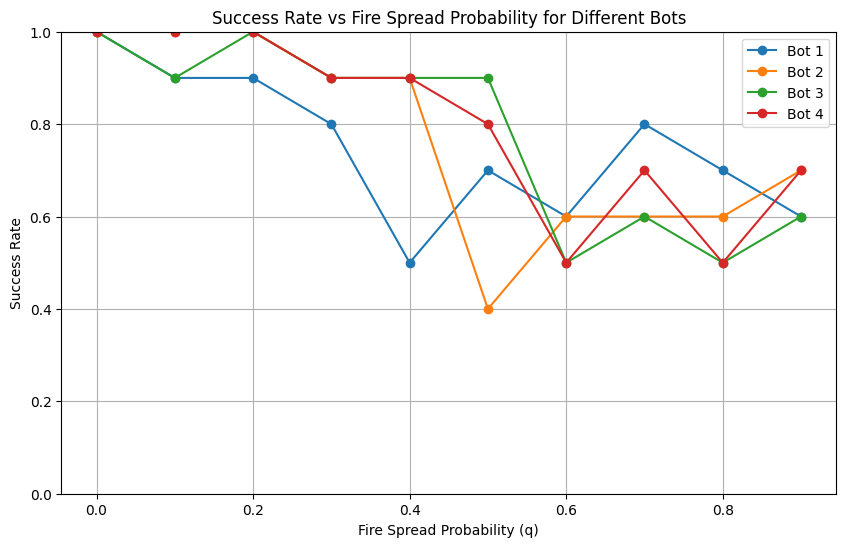

In [ ]:
def run_simulations(simulation: ship, fire_spread_values: List[float], num_trials: int = 100) -> Dict[int, List[float]]:
    bot_success_rates = {1: [], 2: [], 3: [], 4: []}  # Success rates for bots 1-4

    for q in fire_spread_values:
        simulation.q = q
        print(f"Running simulations for fire spread probability: {q}")
        for bot_type in range(1, 5):
            successes = 0
            for trial in range(num_trials):
                simulation.reset()  # Reset the simulation
                result = None
                while result is None:
                    result = simulation.bot_step(bot_type)

                # Count successes
                if result:
                    successes += 1

            success_rate = successes / num_trials
            bot_success_rates[bot_type].append(success_rate)
            print(f"Bot {bot_type} success rate for q={q}: {success_rate}")

    return bot_success_rates

# Function to plot results
def plot_results(fire_spread_values: List[float], success_rates: Dict[int, List[float]]):
    """Plot the success rates of all bots."""
    plt.figure(figsize=(10, 6))
    for bot_type in range(1, 5):
        plt.plot(fire_spread_values, success_rates[bot_type], label=f'Bot {bot_type}', marker='o')

    plt.xlabel('Fire Spread Probability (q)')
    plt.ylabel('Success Rate')
    plt.title('Success Rate vs Fire Spread Probability for Different Bots')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()

# Main simulation and analysis
fire_spread_values = [0.1 * i for i in range(10)]  # From 0 to 0.9 in steps of 0.1
num_trials = 1  # Run 1 trials per bot per fire spread value
simulation = ship()

# Run simulations
success_rates = run_simulations(simulation, fire_spread_values, num_trials)

# Plot the results
plot_results(fire_spread_values, success_rates)

Running simulations for fire spread probability: 0.0
Bot 1 success rate for q=0.0: 1.0
Bot 2 success rate for q=0.0: 1.0
Bot 3 success rate for q=0.0: 1.0
Bot 4 success rate for q=0.0: 1.0
Running simulations for fire spread probability: 0.1
Bot 1 success rate for q=0.1: 0.92
Bot 2 success rate for q=0.1: 1.0
Bot 3 success rate for q=0.1: 0.92
Bot 4 success rate for q=0.1: 0.96
Running simulations for fire spread probability: 0.2
Bot 1 success rate for q=0.2: 0.84
Bot 2 success rate for q=0.2: 0.88
Bot 3 success rate for q=0.2: 1.0
Bot 4 success rate for q=0.2: 0.88
Running simulations for fire spread probability: 0.30000000000000004
Bot 1 success rate for q=0.30000000000000004: 0.8
Bot 2 success rate for q=0.30000000000000004: 0.92
Bot 3 success rate for q=0.30000000000000004: 0.96
Bot 4 success rate for q=0.30000000000000004: 0.84
Running simulations for fire spread probability: 0.4
Bot 1 success rate for q=0.4: 0.72
Bot 2 success rate for q=0.4: 0.8
Bot 3 success rate for q=0.4: 0.6

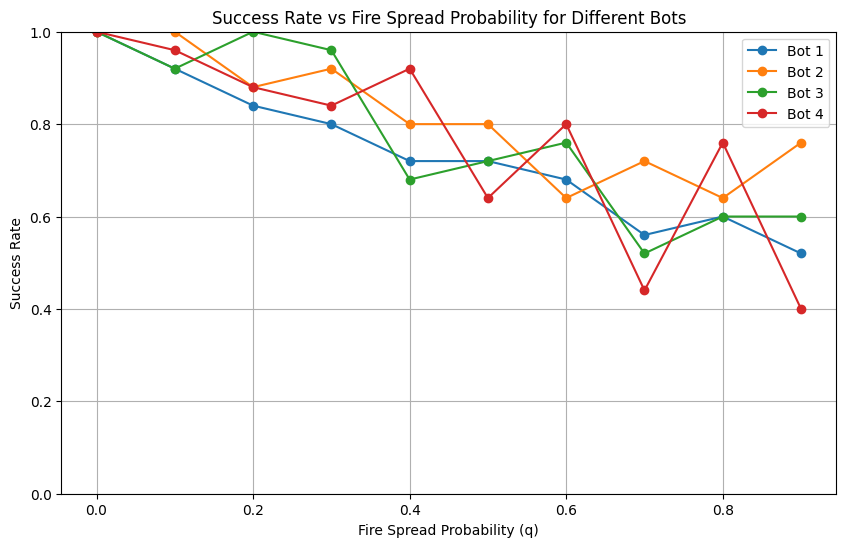

In [ ]:
def run_simulations(simulation: ship, fire_spread_values: List[float], num_trials: int = 100) -> Dict[int, List[float]]:
    bot_success_rates = {1: [], 2: [], 3: [], 4: []}  # Success rates for bots 1-4

    for q in fire_spread_values:
        simulation.q = q
        print(f"Running simulations for fire spread probability: {q}")
        for bot_type in range(1, 5):
            successes = 0
            for trial in range(num_trials):
                simulation.reset()  # Reset the simulation
                result = None
                while result is None:
                    result = simulation.bot_step(bot_type)

                # Count successes
                if result:
                    successes += 1

            success_rate = successes / num_trials
            bot_success_rates[bot_type].append(success_rate)
            print(f"Bot {bot_type} success rate for q={q}: {success_rate}")

    return bot_success_rates

# Function to plot results
def plot_results(fire_spread_values: List[float], success_rates: Dict[int, List[float]]):
    plt.figure(figsize=(10, 6))
    for bot_type in range(1, 5):
        plt.plot(fire_spread_values, success_rates[bot_type], label=f'Bot {bot_type}', marker='o')

    plt.xlabel('Fire Spread Probability (q)')
    plt.ylabel('Success Rate')
    plt.title('Success Rate vs Fire Spread Probability for Different Bots')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()

# Main simulation and analysis
fire_spread_values = [0.1 * i for i in range(10)]  # From 0 to 0.9 in steps of 0.1
num_trials = 25  # Run 25 trials per bot per fire spread value
simulation = ship()

# Run simulations
success_rates = run_simulations(simulation, fire_spread_values, num_trials)

# Plot the results
plot_results(fire_spread_values, success_rates)

In [ ]:
success_rates

{1: [1.0, 0.92, 0.84, 0.8, 0.72, 0.72, 0.68, 0.56, 0.6, 0.52],
 2: [1.0, 1.0, 0.88, 0.92, 0.8, 0.8, 0.64, 0.72, 0.64, 0.76],
 3: [1.0, 0.92, 1.0, 0.96, 0.68, 0.72, 0.76, 0.52, 0.6, 0.6],
 4: [1.0, 0.96, 0.88, 0.84, 0.92, 0.64, 0.8, 0.44, 0.76, 0.4]}

In [ ]:
# Function to plot each bot's graph separately
def plot_individual_bots(fire_spread_values: List[float], success_rates: Dict[int, List[float]]):
    for bot_type in range(1, 5):
        plt.figure(figsize=(8, 5))
        plt.plot(fire_spread_values, success_rates[bot_type], label=f'Bot {bot_type}', marker='o', color=f'C{bot_type}')
        plt.xlabel('Fire Spread Probability (q)')
        plt.ylabel('Success Rate')
        plt.title(f'Success Rate vs Fire Spread Probability for Bot {bot_type}')
        plt.legend()
        plt.grid(True)
        plt.ylim(0, 1)
        plt.show()

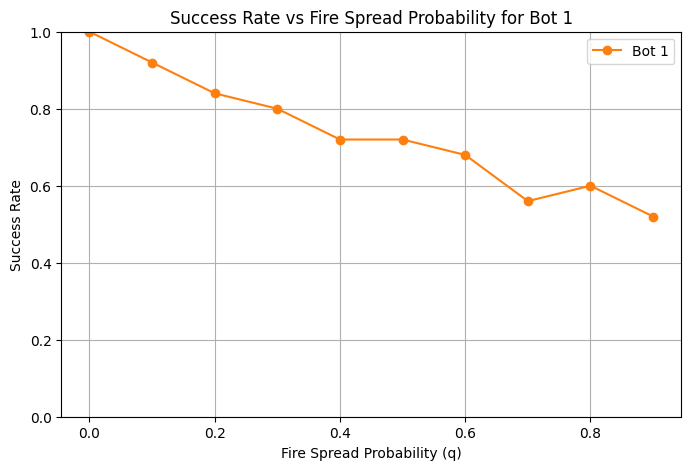

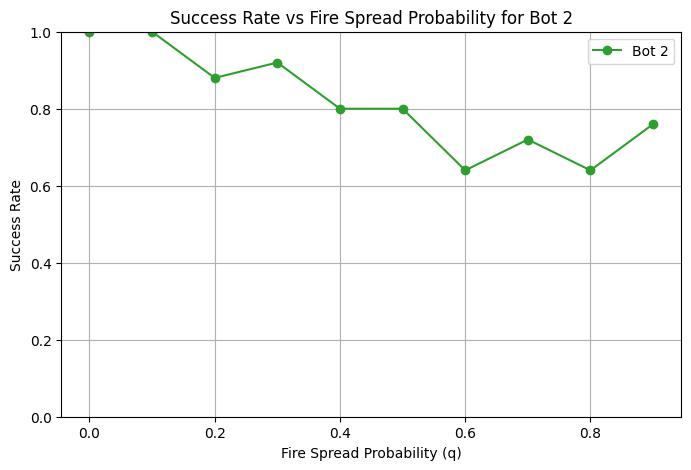

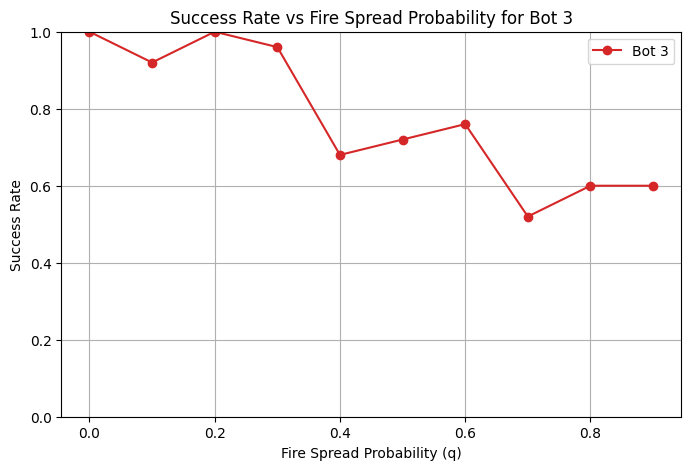

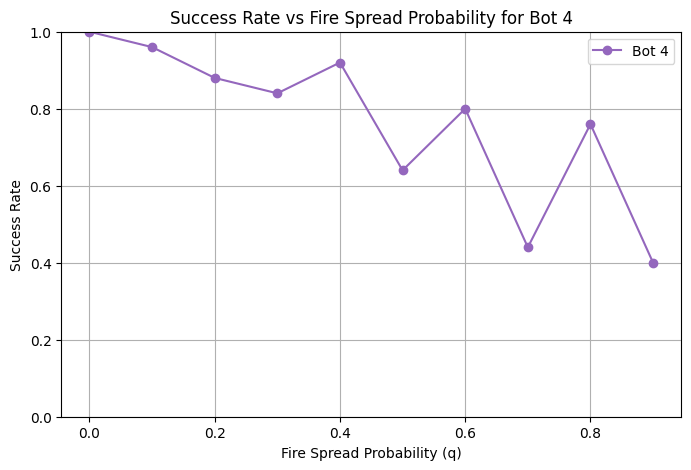

In [ ]:
# Run the individual bot plots
plot_individual_bots(fire_spread_values, success_rates)

In [ ]:
# Function to calculate and plot average accuracy for each bot in percentage
def plot_average_accuracy(success_rates: Dict[int, List[float]]):
    bot_averages = {}

    # Calculate the average success rate for each bot and convert it to percentage
    for bot_type in range(1, 5):
        avg_success_rate = np.mean(success_rates[bot_type]) * 100  # Convert to percentage
        bot_averages[bot_type] = avg_success_rate

    # Plot the average success rates as a bar graph
    plt.figure(figsize=(8, 6))
    bars = plt.bar(bot_averages.keys(), bot_averages.values(), color=['C1', 'C2', 'C3', 'C4'])
    plt.xlabel('Bot Type')
    plt.ylabel('Average Success Rate (%)')
    plt.title('Average Success Rate for Each Bot (in %)')
    plt.ylim(0, 100)
    plt.xticks([1, 2, 3, 4], ['Bot 1', 'Bot 2', 'Bot 3', 'Bot 4'])

    # Add percentage labels above the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom')

    plt.show()

    return bot_averages

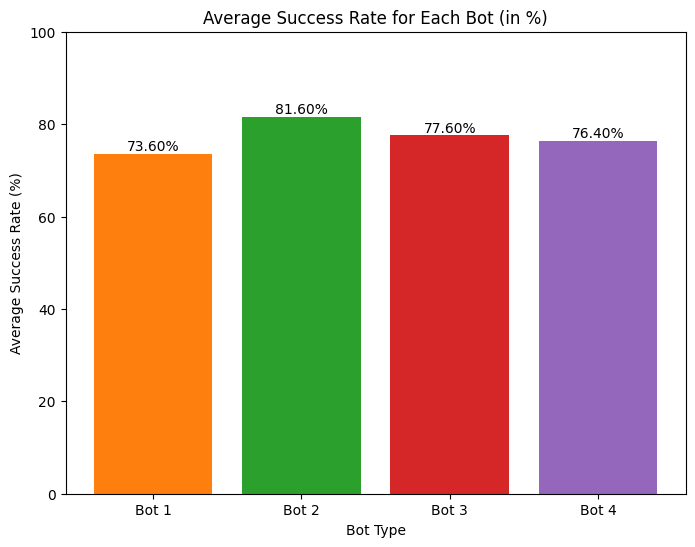

Bot 1 Average Success Rate: 73.60%
Bot 2 Average Success Rate: 81.60%
Bot 3 Average Success Rate: 77.60%
Bot 4 Average Success Rate: 76.40%


In [ ]:
# Calculate and plot the average accuracy in percentage
average_success_rates = plot_average_accuracy(success_rates)

# Display the average success rates in percentage for reference
for bot, avg_rate in average_success_rates.items():
    print(f"Bot {bot} Average Success Rate: {avg_rate:.2f}%")  # Print in percentage form